# Life Expectancy Data Science Project

---------------------------------------------

### Introduction
This analysis explores a life expectancy dataset, aiming to uncover factors affecting life expectancy across countries over time. We'll handle missing values, engineer features, perform exploratory analysis, visualize patterns, and build a regression model to predict life expectancy.

### Objectives
- Understand the structure and quality of the dataset
- Identify key features affecting life expectancy
- Handle missing data appropriately
- Engineer new features to improve prediction
- Visualize relationships and trends
- Build a regression model to predict life expectancy
- Evaluate model performance using cross-validation
- Derive actionable insights

### Task 1: Explore Dataset and Missing Values

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from scipy.stats.mstats import winsorize
import re
from scipy.stats import median_abs_deviation
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [ ]:
df = pd.read_csv('Life_Expectancy_Data.csv')
df.shape 

In [ ]:
df.dtypes

In [ ]:
df.dtypes.value_counts()

In [ ]:
df.columns

In [ ]:

for column in df.columns:
    # Remove leading/trailing spaces and compress multiple spaces into single spaces
    cleaned_column = re.sub(r'\s+', ' ', column.strip())
    df.rename(columns={column: cleaned_column}, inplace=True)


df.to_csv("Cleaned_Life_Expectancy.csv", index=False)
df.columns


#### Statistical analysis

In [ ]:
# Display all columns in the DataFrame
pd.set_option('display.max_columns', None)
#Description of the dataset transposed
df.describe(include='all')

In [ ]:
df.head(20)

In [ ]:
print(df.duplicated())

In [ ]:
#Find total of duplicated values
print(df.duplicated().sum())

In [ ]:
# Get the number of unique countries from the 'Country' column
number_of_countries = df['Country'].nunique()

# Print the number of unique countries
print(f"The total number of unique countries in the dataset is: {number_of_countries}")

### Task 2: Handle Missing Data and Justify Method

In [ ]:
null_values = df.isnull().sum()

In [ ]:
#Checks if any column has NaN
df.isnull().any()

In [ ]:
#Checks if any row has NaN
df.isnull().any(axis=1)

In [ ]:
#Checks if all values in a column are NaN
df.isnull().all()

In [ ]:
#Checks if all values in a row are NaN
df.isnull().all(axis=1)

In [ ]:
null_percentage = (df.isnull().sum() / len(df))*100
print(null_percentage)

In [ ]:
missing_df = pd.DataFrame({'Missing Values': null_values, 'Percent Missing': null_percentage})
missing_df[missing_df['Missing Values'] > 0]

### Advanced mechanisms to handle missing data

#### Outlier detection
1. Z-Score

In [ ]:

# === Initialize tracker ===
outlier_indices_per_column = {col: set() for col in df.select_dtypes(include='number').columns}

# === Z-Score function ===
def detect_outliers(series, threshold=3.5):
    median = series.median()
    mad = median_abs_deviation(series, scale='normal')  # scaled to be comparable to std
    if mad == 0:
        return pd.Series([False] * len(series), index=series.index)
    z_scores = 0.6745 * (series - median) / mad
    return abs(z_scores) > threshold

# === Process per country ===
for country, group in df.groupby('Country'):
    for col in df.select_dtypes(include='number').columns:
        is_outlier = detect_outliers(group[col])
        outlier_indices_per_column[col].update(group[is_outlier].index)

# === Build summary table ===
summary = []
for col, indices in outlier_indices_per_column.items():
    count = len(indices)
    summary.append({
        'Column': col,
        'Outlier Count': count,
        'Percentage': round((count / len(df)) * 100, 2)
    })

# === Create DataFrame and show results ===
outlier_summary = pd.DataFrame(summary).sort_values(by='Outlier Count', ascending=False)

print("Outlier Detection Summary (Z-Score per Country, Unique Rows Only)")
print("=" * 70)
print(outlier_summary.to_string(index=False))


2. Box plot

In [ ]:
# === First feature group ===
features_1 = ['Polio', 'Diphtheria', 'Income composition of resources',
              'HIV/AIDS', 'thinness 1-19 years', 'thinness 5-9 years']

# === Second feature group ===
features_2 = ['Measles', 'GDP', 'percentage expenditure', 'Adult Mortality', 'under-five deaths', 'Total expenditure']

features_3 = ['Population', 'Alcohol', 'Schooling', 'BMI', 'Life expectancy', 'Hepatitis B']

# === Prepare melted data for both groups ===
def melt_and_tag_outliers(df, features):
    melted = df[['Country'] + features].melt(id_vars='Country', var_name='Feature', value_name='Value')

    def detect_and_tag_outliers(group):
        q1 = group['Value'].quantile(0.25)
        q3 = group['Value'].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        group['Outlier'] = (group['Value'] < lower) | (group['Value'] > upper)
        return group

    tagged = melted.groupby(['Country', 'Feature'], group_keys=False).apply(detect_and_tag_outliers)
    return tagged

df_tagged_1 = melt_and_tag_outliers(df, features_1)
df_tagged_2 = melt_and_tag_outliers(df, features_2)
df_tagged_3 = melt_and_tag_outliers(df, features_3)

# === Create subplots ===
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(14, 30))  # reduce figure height


# --- Plot 1 ---
sns.boxplot(data=df_tagged_1, x='Feature', y='Value', showfliers=False, ax=ax1)
sns.stripplot(
    data=df_tagged_1[df_tagged_1['Outlier']],
    x='Feature',
    y='Value',
    hue='Country',
    dodge=True,
    jitter=True,
    marker='o',
    alpha=0.6,
    linewidth=0.5,
    edgecolor='gray',
    palette='tab20',
    ax=ax1
)
ax1.set_title("Group 1: Country-Based Outliers (Polio, Diphtheria, etc.)")
ax1.tick_params(axis='x', rotation=45)
ax1.legend_.remove()


# --- Plot 2 ---
sns.boxplot(data=df_tagged_2, x='Feature', y='Value', showfliers=False, ax=ax2)
sns.stripplot(
    data=df_tagged_2[df_tagged_2['Outlier']],
    x='Feature',
    y='Value',
    hue='Country',
    dodge=True,
    jitter=True,
    marker='o',
    alpha=0.6,
    linewidth=0.5,
    edgecolor='gray',
    palette='tab20',
    ax=ax2
)
ax2.set_title("Group 2: Country-Based Outliers (Measles, GDP, etc.)")
ax2.tick_params(axis='x', rotation=45)

ax2.legend_.remove()

# --- Plot 3 ---
sns.boxplot(data=df_tagged_3, x='Feature', y='Value', showfliers=False, ax=ax3)
sns.stripplot(
    data=df_tagged_3[df_tagged_3['Outlier']],
    x='Feature',
    y='Value',
    hue='Country',
    dodge=True,
    jitter=True,
    marker='o',
    alpha=0.6,
    linewidth=0.5,
    edgecolor='gray',
    palette='tab20',
    ax=ax3
)
ax3.set_title("Group 3: Country-Based Outliers (Population, Alcohol, etc.)")
ax3.tick_params(axis='x', rotation=45)
ax3.legend_.remove()


# === Add legend outside the full figure ===
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, title='Country', bbox_to_anchor=(1.02, 0.5), loc='center left')
plt.show()


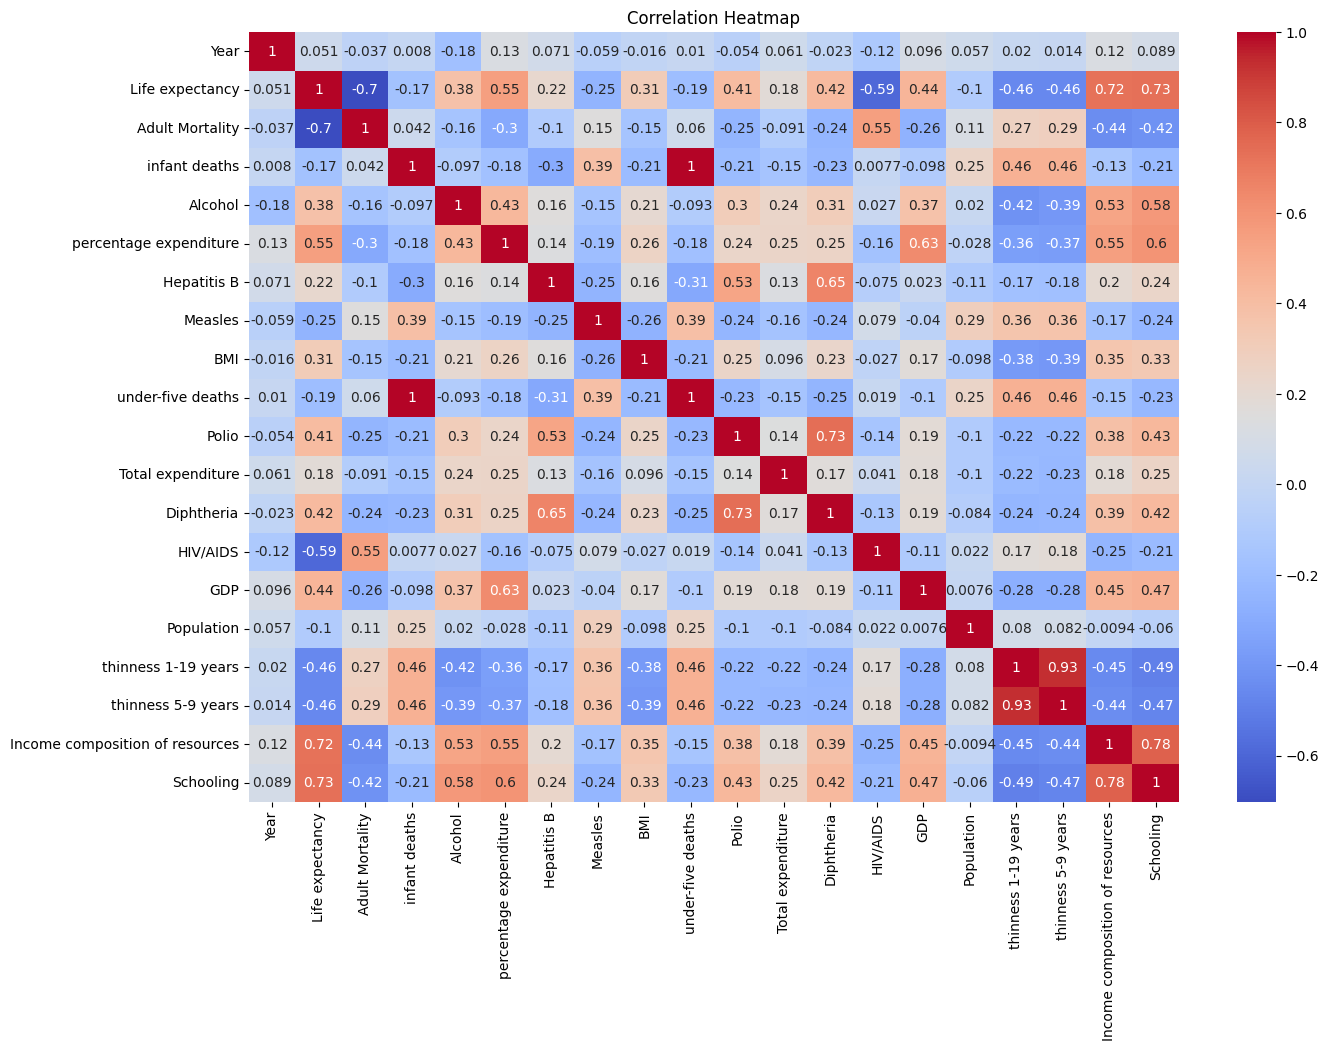

In [47]:
plt.figure(figsize=(15,10))
sns.heatmap(df.select_dtypes(include='number').corr(), cmap='coolwarm', annot=True)
plt.title('Correlation Heatmap')
plt.show()

### Task 3: Apply Chosen Method and Evaluate

### Implementation of the chosen methods

In [ ]:
# These will use percentile-based capping due to skewness
skewed_features = ['Adult Mortality']
# These will use IQR capping
iqr_features = ['Polio', 'Diphtheria', 'Hepatitis B',
                'Total expenditure']
# These will use log transformation
log_transform_features = ['Measles', 'Population', 'Alcohol', 'percentage expenditure']

# Features to process (but we'll keep all other features unchanged)
features_to_process = skewed_features + iqr_features + log_transform_features 

# === Impute missing values using country-wise median for ALL features ===
print("🔧 Imputing missing values with country-wise median...")
# Get all numeric columns except Country and Year
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Remove Country and Year if they exist in numeric columns
numeric_cols = [col for col in numeric_cols if col not in ['Country', 'Year']]

for col in numeric_cols:
    if col in df.columns and df[col].isnull().any():
        df[col] = df.groupby('Country')[col].transform(lambda x: x.fillna(x.median()))
        if df[col].isnull().any():
            df[col].fillna(df[col].median(), inplace=True)
print("Imputation complete.")

# === Helper Functions ===

def percentile_cap_grouped(df, col, lower=0.01, upper=0.99):
    """Apply percentile capping per country."""
    def cap(x):
        return x.clip(lower=x.quantile(lower), upper=x.quantile(upper))
    return df.groupby("Country")[col].transform(cap)

def iqr_cap_grouped(df, col):
    """Apply IQR capping per country."""
    def cap(x):
        q1 = x.quantile(0.25)
        q3 = x.quantile(0.75)
        iqr = q3 - q1
        if iqr == 0 or x.isnull().all():
            return x
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        return x.clip(lower, upper)
    return df.groupby("Country")[col].transform(cap)

def apply_log_transform_safely(x):
    """Log transform safely, avoiding log(0)."""
    return np.log1p(x.clip(lower=0))

# === Apply transformations ONLY to specified features ===
print("\nApplying transformations and tracking changes...")
df_cleaned = df.copy()
changes_summary = {}



# 2. IQR Capping → other features
for col in iqr_features:
    if col in df_cleaned.columns:
        before = df_cleaned[col].copy()
        df_cleaned[col] = iqr_cap_grouped(df_cleaned, col)
        changes_summary[col] = (df_cleaned[col] != before).sum()
        print(f"✔ IQR Capped → {col}: {changes_summary[col]} values modified")

# 3. Log Transform → log_transform_features
for col in log_transform_features:
    if col in df_cleaned.columns:
        before = df_cleaned[col].copy()
        df_cleaned[col] = apply_log_transform_safely(df_cleaned[col])
        changes_summary[col] = (df_cleaned[col] != before).sum()
        print(f"✔ Log Transformed → {col}: {changes_summary[col]} values modified")

# === Save cleaned dataset with ALL original features ===
# Keep all columns from the original dataset
df_final = df_cleaned.copy()
df_final.to_csv("Cleaned_Life_Expectancy.csv", index=False)

# === Summary ===
print("Final Summary of Outlier Handling:")
for col, count in changes_summary.items():
    if col in iqr_features:
        method = "IQR Capped"
    else:
        method = "Log Transformed"
    print(f"✔ {method} → {col}: {count} values modified")

print(f"Dataset Info:")
print(f"Total columns in cleaned dataset: {len(df_final.columns)}")
print(f"Columns processed: {len(features_to_process)}")
print(f"Columns unchanged: {len(df_final.columns) - len(features_to_process)}")

print("Cleaned dataset saved as: Cleaned_Life_Expectancy.csv")


In [ ]:
# Handling missing values for BMI separately
df = pd.read_csv('Cleaned_Life_Expectancy.csv')
# === Step 1: Identify and mask biologically implausible BMI values ===
# Values outside a reasonable range for a national average are considered invalid.
invalid_bmi_mask = (df['BMI'] < 15) | (df['BMI'] > 40)
num_bmi_replaced = invalid_bmi_mask.sum()

print(f"🔧 Identified {num_bmi_replaced} invalid BMI values to be imputed.")

# Replace these invalid values with NaN so they can be imputed
df['BMI'] = df['BMI'].mask(invalid_bmi_mask, np.nan)


# === Step 2: Impute missing BMI values using MICE ===
# MICE will predict missing BMI values based ONLY on Life expectancy, as requested.
impute_cols = ['Life expectancy', 'BMI']

imputer = IterativeImputer(max_iter=10, random_state=42)

# The imputer will predict the missing 'BMI' values based on 'Life expectancy'.
# The result is assigned back to the correct columns in the main DataFrame.
df[impute_cols] = imputer.fit_transform(df[impute_cols])
print("BMI values imputed successfully using MICE.")


# === Step 3: Save the ENTIRE cleaned dataset ===
# This saves the full DataFrame with all original columns, plus the cleaned BMI column.
df.to_csv('Cleaned_Life_Expectancy.csv', index=False)
print("Full dataset with cleaned BMI saved to 'Cleaned_Life_Expectancy.csv'")


# --- Output Summary ---
print("\nFinal Cleaned Dataset (Sample):")
# Displaying more columns to confirm they were all kept
print(df.head(10))

In [ ]:
# Handling missing values for GDP separately
df = pd.read_csv('Cleaned_Life_Expectancy.csv')
# --- Step 0: Initial State ---
print("\n--- Initial State of GDP Column ---")
initial_missing_gdp = df['GDP'].isnull().sum()
print(f"Number of missing GDP values initially: {initial_missing_gdp}")

# --- Step 1: Detect Outliers on a Per-Country Basis ---
print("\n--- Step 1: Detecting Outliers for Each Country Individually ---")

def get_country_upper_bound(series):
    """Calculates the upper outlier bound for a pandas Series."""
    q3 = series.quantile(0.75)
    iqr = q3 - series.quantile(0.25)
    return q3 + 1.5 * iqr

def get_country_lower_bound(series):
    """Calculates the lower outlier bound, enforcing a domain-specific minimum."""
    q1 = series.quantile(0.25)
    iqr = series.quantile(0.75) - q1
    iqr_lower_bound = q1 - 1.5 * iqr
    # Set an absolute minimum plausible value for GDP per capita
    domain_lower_bound = 100.0
    # Use the larger of the two lower bounds to be less restrictive, but never go below our absolute minimum.
    return max(iqr_lower_bound, domain_lower_bound)

# Apply outlier bound calculations for each country
country_upper_bounds = df.groupby('Country')['GDP'].transform(get_country_upper_bound)
country_lower_bounds = df.groupby('Country')['GDP'].transform(get_country_lower_bound)

# Create a boolean mask to identify rows with outlier GDP values
outlier_mask = (df['GDP'] < country_lower_bounds) | (df['GDP'] > country_upper_bounds)
outliers = df[outlier_mask]

print(f"Number of GDP outliers detected across all countries: {len(outliers)}")
if not outliers.empty:
    print("Sample of detected outliers:")
    print(outliers[['Country', 'Year', 'GDP']].head())

# --- Step 2: Mark Outliers as NaN ---
print("\n--- Step 2: Marking Outliers as Invalid (NaN) ---")
df.loc[outlier_mask, 'GDP'] = np.nan
total_missing_after_marking = df['GDP'].isnull().sum()
print(f"Total GDP values now missing (NaN): {total_missing_after_marking}")

# --- Step 3: Impute with Country-Specific Mean ---
print("\n--- Step 3: Imputing Missing/Invalid Values ---")
# Calculate the mean of valid GDPs for each country
country_gdp_mean = df.groupby('Country')['GDP'].transform('mean')
# Fill NaN values with the respective country's mean
df['GDP'].fillna(country_gdp_mean, inplace=True)

# Fallback to global mean if any country had all its values as NaN
global_gdp_mean = df['GDP'].mean()
df['GDP'].fillna(global_gdp_mean, inplace=True)
print("GDP values imputed successfully.")

# --- Step 4: Save the ENTIRE cleaned dataset ---
# This saves the full DataFrame with all original columns, plus the cleaned GDP column.
df.to_csv("Cleaned_Life_Expectancy.csv", index=False)
print("Full dataset with cleaned GDP saved to 'Cleaned_Life_Expectancy.csv'")

# --- Output Summary ---
print("\nFinal Cleaned Dataset (Sample):")
# Displaying the head of the full dataframe to confirm all columns were kept
print(df.head(10))

### Box plot to inspect cleaned features

In [ ]:

# === First feature group ===
features_1 = ['Polio', 'Diphtheria', 'HIV/AIDS', 'Measles', 'GDP', 'percentage expenditure']

# === Second feature group ===
features_2 = ['Total expenditure', 'Adult Mortality', 'Alcohol', 'Population']

# === Prepare melted data for both groups ===
def melt_and_tag_outliers(df, features):
    melted = df[['Country'] + features].melt(id_vars='Country', var_name='Feature', value_name='Value')

    def detect_and_tag_outliers(group):
        q1 = group['Value'].quantile(0.25)
        q3 = group['Value'].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        group['Outlier'] = (group['Value'] < lower) | (group['Value'] > upper)
        return group

    tagged = melted.groupby(['Country', 'Feature'], group_keys=False).apply(detect_and_tag_outliers)
    return tagged

df_tagged_1 = melt_and_tag_outliers(df, features_1)
df_tagged_2 = melt_and_tag_outliers(df, features_2)

# === Create subplots ===
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(14, 30))  # reduce figure height


# --- Plot 1 ---
sns.boxplot(data=df_tagged_1, x='Feature', y='Value', showfliers=False, ax=ax1)
sns.stripplot(
    data=df_tagged_1[df_tagged_1['Outlier']],
    x='Feature',
    y='Value',
    hue='Country',
    dodge=True,
    jitter=True,
    marker='o',
    alpha=0.6,
    linewidth=0.5,
    edgecolor='gray',
    palette='tab20',
    ax=ax1
)
ax1.set_title("Group 1: Country-Based Outliers (Polio, Diphtheria, etc.)")
ax1.tick_params(axis='x', rotation=45)
ax1.legend_.remove()


# --- Plot 2 ---
sns.boxplot(data=df_tagged_2, x='Feature', y='Value', showfliers=False, ax=ax2)
sns.stripplot(
    data=df_tagged_2[df_tagged_2['Outlier']],
    x='Feature',
    y='Value',
    hue='Country',
    dodge=True,
    jitter=True,
    marker='o',
    alpha=0.6,
    linewidth=0.5,
    edgecolor='gray',
    palette='tab20',
    ax=ax2
)
ax2.set_title("Group 2: Country-Based Outliers (Measles, GDP, etc.)")
ax2.tick_params(axis='x', rotation=45)

ax2.legend_.remove()

# === Add legend outside the full figure ===
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, title='Country', bbox_to_anchor=(1.02, 0.5), loc='center left')
plt.show()


### Task 4: Identify Potential Features

In [ ]:
# Variance Inflation Factor to measure multicollinearity
# High VIF (> 10): The feature is highly redundant — it’s linearly predictable from other features.
#Low VIF (< 5): Low multicollinearity — the feature gives unique information.


X = df_final.select_dtypes(include=[float, int]).drop(columns=['Life expectancy'])
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data.sort_values('VIF', ascending=False))

In [ ]:
selected_features = [
    'Adult Mortality',
    'Alcohol',
    'Total expenditure',
    'Measles',
    'HIV/AIDS',
    'GDP',
    'BMI'
]

###  Task 5: Feature Engineering

In [ ]:
df_final['Immunization Score'] = df_final[['Polio', 'Diphtheria', 'Hepatitis B']].mean(axis=1)
df_final['HIV Impact Score'] = df_final['HIV/AIDS'] * df_final['Adult Mortality']
df_final['Health Investment'] = df_final['percentage expenditure'] * df_final['GDP']
df_final['Healthcare Access Ratio'] = df_final['Total expenditure'] / (df_final['GDP'] + 1e-5)
df_final['Mortality Rate Ratio'] = df_final['Adult Mortality'] / (df_final['Life expectancy'] + 1e-5)
df_final['Schooling vs Alcohol'] = df_final['Schooling'] / (df_final['Alcohol'] + 1e-5)
df_final['Resource Efficiency'] = df_final['Income composition of resources'] * df_final['Schooling']
df_final['Health Spending Per Capita'] = df_final['Total expenditure'] / (df_final['Population'] + 1e-5)
df_final['Population GDP Ratio'] = df_final['Population'] / (df_final['GDP'] + 1e-5)
df_final['BMI Deviation'] = abs(df_final['BMI'] - 22.5)
df_final['Thinness Ratio'] = df_final['thinness 1-19 years'] / (df_final['thinness 5-9 years'] + 1e-5)
df_final['Healthcare Access Score'] = df_final['Immunization Score'] * df_final['Health Investment']
df_final['GDP per Health $'] = df_final['GDP'] / (df_final['Total expenditure'] + 1e-5)
df_final['Child Vulnerability Index'] = 0.6 * df_final['HIV/AIDS'] + 0.4 * (df_final['under-five deaths'] + df_final['infant deaths'])

### Task 6: Impact of New Features

In [ ]:
# Features before engineering
X_base = df_final[selected_features]
y = df_final['Life expectancy']

# Cross-validation with original features
base_model = LinearRegression()
base_score = cross_val_score(base_model, X_base, y, cv=5, scoring='r2').mean()

# Features after adding engineered ones
engineered_features = ['Immunization Score', 'Health Investment', 'Healthcare Access Ratio', 
                       'Mortality Rate Ratio', 'Schooling vs Alcohol', 
                       'Resource Efficiency', 'Health Spending Per Capita', 'Population GDP Ratio', 'BMI Deviation', 'Thinness Ratio',
                       'Healthcare Access Score', 'GDP per Health $', 'HIV Impact Score']
X_eng = df_final[selected_features + engineered_features]

# Cross-validation with engineered features
eng_model = LinearRegression()
eng_score = cross_val_score(eng_model, X_eng, y, cv=5, scoring='r2').mean()

print(f"R² (Base Features Only): {base_score:.4f}")
print(f"R² (With Engineered Features): {eng_score:.4f}")


### Task 7: Select Key Variables for Visualization

In [ ]:
df[['Life expectancy', 'GDP', 'Schooling', 'Alcohol', 'BMI', 'HIV/AIDS']].corr()

### Task 8: Visualizations

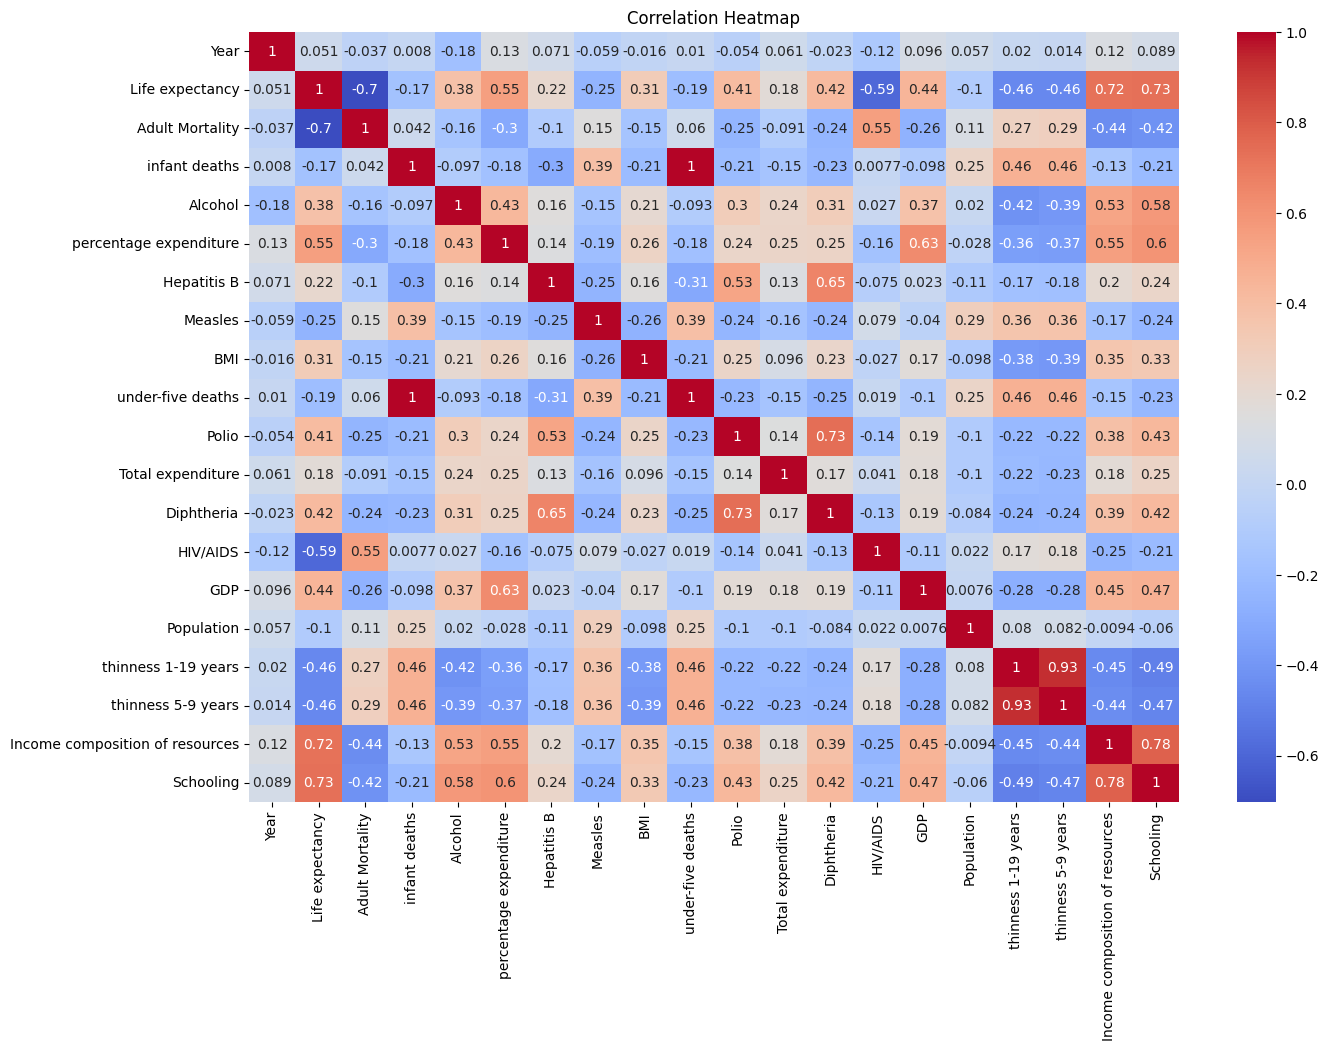

In [48]:
plt.figure(figsize=(15,10))
sns.heatmap(df.select_dtypes(include='number').corr(), cmap='coolwarm', annot=True)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
plt.figure(figsize=(8,6))
sns.boxplot(x='Status', y='Life expectancy', data=df)
plt.title('Life Expectancy by Development Status')
plt.show()

In [ ]:
avg_life = df_final.groupby('Country')['Life expectancy'].mean().sort_values(ascending=False).head(10)
avg_life.plot(kind='bar', title='Top 10 Countries by Avg Life Expectancy')



In [ ]:
# Create the pairplot with hue (e.g., by 'Status' column: 'Developed' or 'Developing')
plot = sns.pairplot(
    df_final[['Life expectancy', 'HIV/AIDS', 'percentage expenditure', 
              'Schooling', 'Alcohol', 'Income composition of resources', 'Status']],
    hue='Status',                    # Add color grouping by 'Status'
    diag_kind='kde',                # KDE for diagonal plots
    palette='Set2',                 # Choose a readable color palette
    corner=True                     # Optional: show only lower triangle to avoid repetition
)

# Add a title to the figure
plot.fig.suptitle("Pairplot of Key Features Grouped by Country Status", y=1.02, fontsize=16)

# Show the legend (usually shown by default with hue, but you can reposition or customize it)
plot._legend.set_title("Country Status")  # Custom legend title

plt.show()



In [ ]:
sns.violinplot(x='Status', y='Immunization Score', data=df_final)
plt.title("Immunization Score by Country Type")


In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='Alcohol', y='Life expectancy', hue='Status')
plt.title('Life Expectancy vs Alcohol')
plt.show()

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='Hepatitis B', y='Life expectancy', hue='Status')
plt.title('Life Expectancy vs Hepatitis B')
plt.show()

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='HIV/AIDS', y='Life expectancy', hue='Status')
plt.title('Life Expectancy vs HIV/AIDS')
plt.show()

In [51]:
# 3D Plot
fig = px.scatter_3d(df, x='HIV/AIDS', y='Adult Mortality', z='Life expectancy',
    color='Status', size='Population')
fig.show()

In [52]:
fig = px.scatter_3d(df_final,
    x='GDP',
    y='Health Investment',
    z='Life expectancy',
    color='Status',
    hover_name='Country',
    size='Population',
    title="3D Plot: GDP vs Health Investment vs Life Expectancy")

fig.show()


### Task 9: Interpretation
- Higher GDP and schooling are associated with higher life expectancy.
- Developing countries tend to have more outliers and lower average life expectancy.
- HIV/AIDS has a strong negative correlation with life expectancy.

### Task 10: Data Splitting and Model Training

In [ ]:
X = df_final[selected_features + engineered_features]
 
y = df_final['Life expectancy']

# Split the data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}

print(f"{'Model':<25}{'Train R²':>12}{'Test R²':>12}")
print("=" * 50)

for name, model in models.items():
    model.fit(X_train, y_train)
    r2_train = r2_score(y_train, model.predict(X_train))
    r2_test = r2_score(y_test, model.predict(X_test))
    print(f"{name:<25}{r2_train:>12.4f}{r2_test:>12.4f}")

### Task 11: Cross Validation and Model Evaluation

In [ ]:
print(f"{'Model':<25}{'CV R² (Mean)':>15}{'Std Dev':>12}{'MAE (Mean)':>15}")
print("=" * 70)

for name, model in models.items():
    # R² scores
    r2_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    
    # MAE scores (note: cross_val_score returns negative MAE)
    mae_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
    mae_scores = -mae_scores  # Convert to positive

    print(f"{name:<25}{np.mean(r2_scores):>15.4f}{np.std(r2_scores):>12.4f}{np.mean(mae_scores):>15.4f}")


### Task 12: Conclusion and Recommendations
- **Key Findings**: Life expectancy is positively influenced by GDP, schooling, and healthcare access. HIV/AIDS is a major negative predictor.
- **Model Performance**: The linear model gives reasonable accuracy with cross-validation.
- **Recommendation**: Focus on improving education, economic stability, and healthcare to raise life expectancy.